# Bagian Baru

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import shutil             # to copy images to another directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

In [2]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

100%|██████████| 239M/239M [00:02<00:00, 108MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1


In [4]:
dataDirList = ['/root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1/garbage_classification']

In [5]:
selectedClasses = ['battery' , 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [6]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)

In [7]:
# Convert the 2 lists to dataframe to easy use
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle

df

,imgPath,label
0,/root/.cache/kagglehub/datasets/mostafaabla/ga...,clothes
1,/root/.cache/kagglehub/datasets/mostafaabla/ga...,plastic
2,/root/.cache/kagglehub/datasets/mostafaabla/ga...,clothes
3,/root/.cache/kagglehub/datasets/mostafaabla/ga...,battery
4,/root/.cache/kagglehub/datasets/mostafaabla/ga...,glass
...,...,...
15510,/root/.cache/kagglehub/datasets/mostafaabla/ga...,clothes
15511,/root/.cache/kagglehub/datasets/mostafaabla/ga...,plastic
15512,/root/.cache/kagglehub/datasets/mostafaabla/ga...,green-glass
15513,/root/.cache/kagglehub/datasets/mostafaabla/ga...,clothes


In [8]:
# get the ratio such as 15% of each class for testing, 10% for validation, and 75% for training
def DataFrameSpliting(df , train_ratio , val_ratio , test_ratio , classesList):

    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    valDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])

    for clas in classesList :
        tempDf = df[df['label'] == clas]
        train_end = int(len(tempDf) * train_ratio)
        val_end = int(len(tempDf) * (train_ratio + val_ratio))

        trainClassDf = tempDf[:train_end]
        valClassDf = tempDf[train_end:val_end]
        testClassDf = tempDf[val_end:]

        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        valDf = pd.concat([valDf , valClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)

    return trainDf.sample(frac=1).reset_index(drop=True), valDf.sample(frac=1).reset_index(drop=True), testDf.sample(frac=1).reset_index(drop=True)

In [9]:
classList = list(df['label'].unique())
trainDf , valDf , testDf = DataFrameSpliting(df , 0.80 , 0.1 , 0.1 , classList)

In [10]:
trainDf['label'].value_counts()

,count
label,
clothes,4260
shoes,1581
paper,840
biological,788
battery,756
cardboard,712
plastic,692
glass,620
metal,615


In [11]:
valDf['label'].value_counts()

,count
label,
clothes,532
shoes,198
paper,105
biological,98
battery,94
cardboard,89
plastic,86
metal,77
glass,77


In [12]:
testDf['label'].value_counts()

,count
label,
clothes,533
shoes,198
paper,105
biological,99
battery,95
cardboard,90
plastic,87
glass,78
metal,77


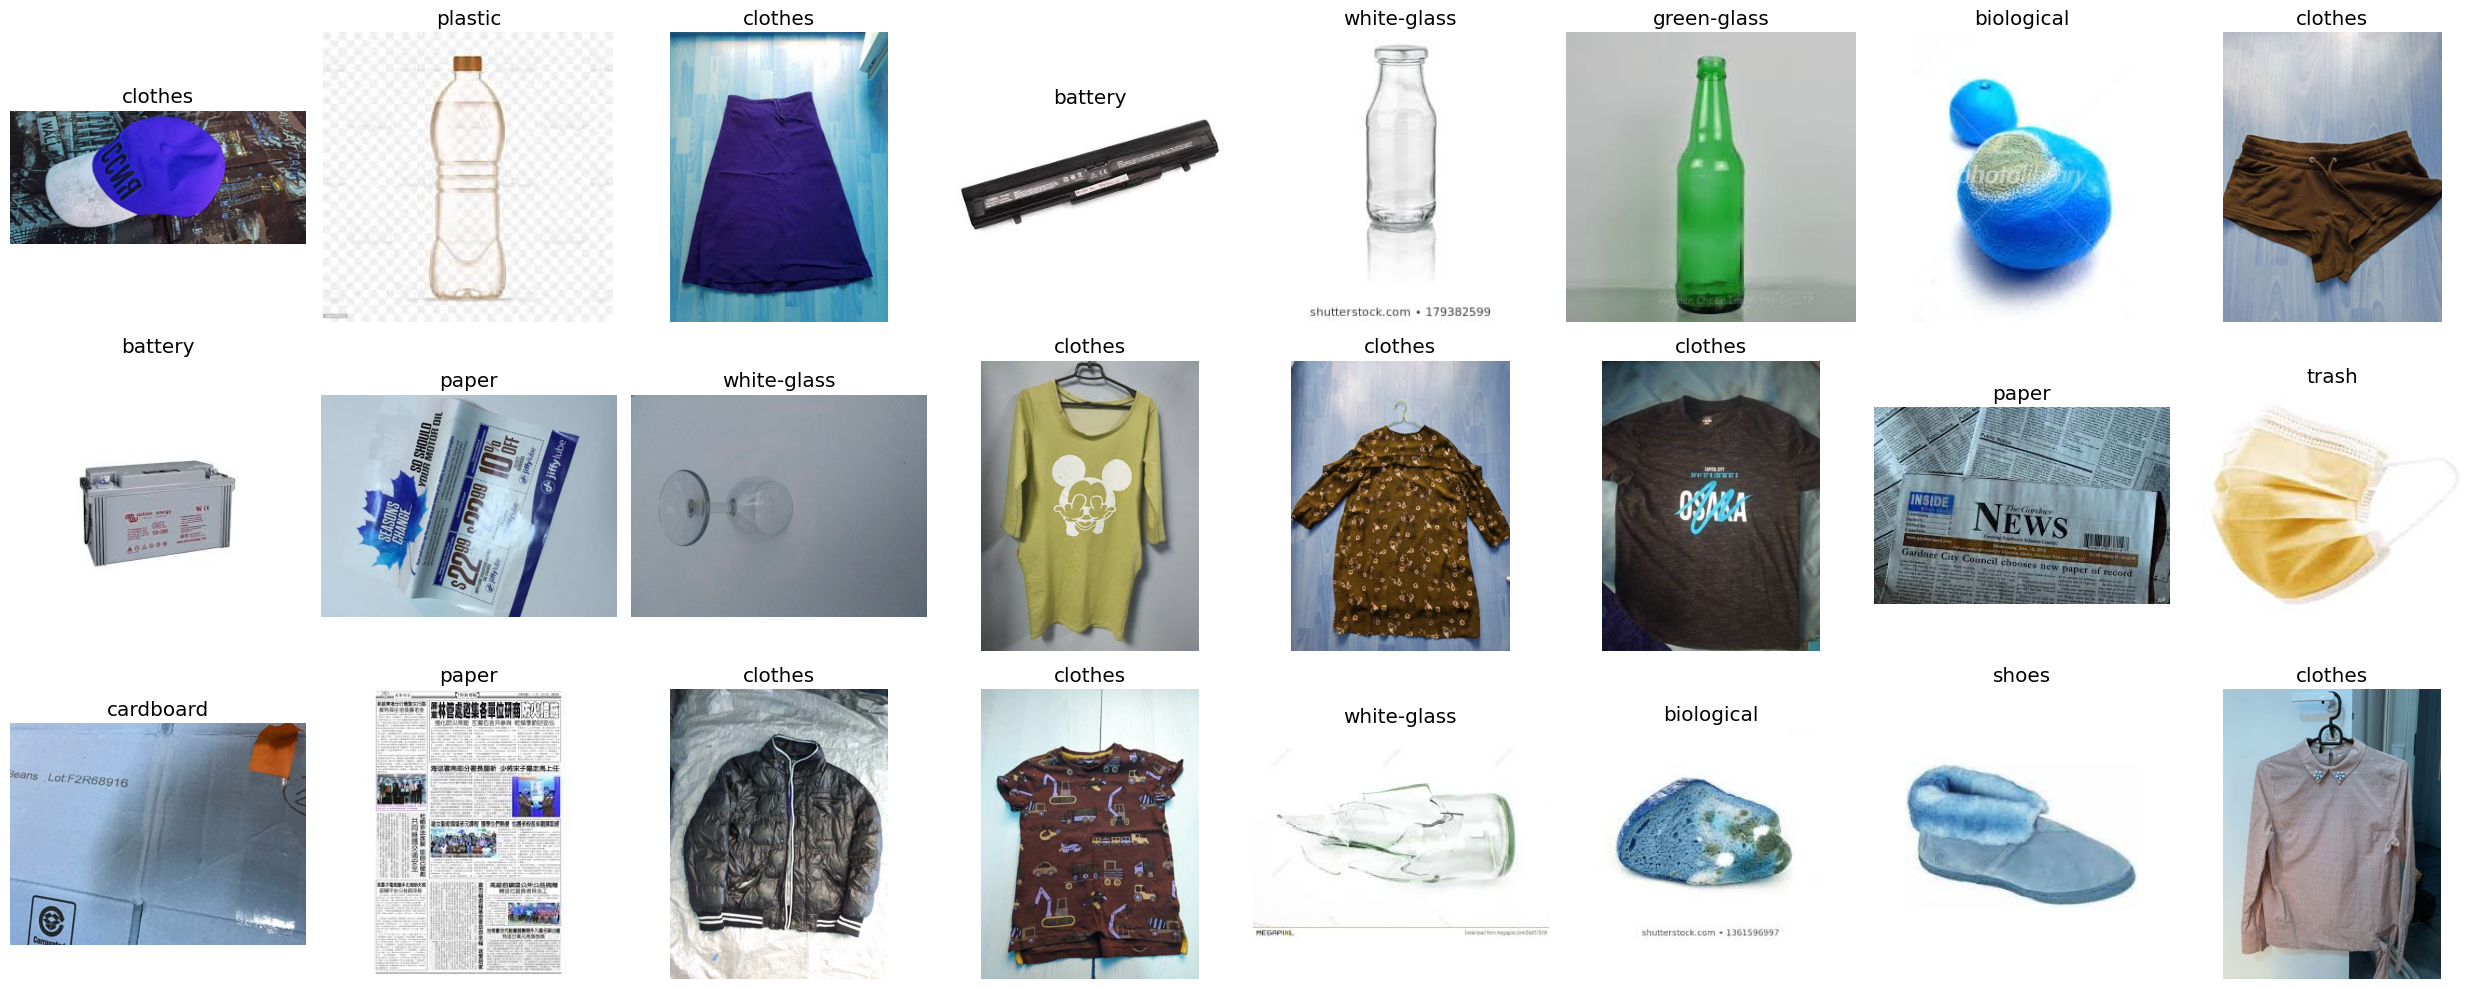

In [13]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax, imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an image from a path
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [14]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom in
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [15]:
IMG_SIZE = (224,224)

In [16]:
trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once
    class_mode='categorical'
)

Found 12409 validated image filenames belonging to 12 classes.


In [17]:
datagenVal = ImageDataGenerator( rescale=1./255 )

valGenerator = datagenVal.flow_from_dataframe(
    valDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)

Found 1550 validated image filenames belonging to 12 classes.


In [18]:
datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)

Found 1556 validated image filenames belonging to 12 classes.


In [19]:
print(f"Training set size: {trainGenerator.samples}")
print(f"Validation set size: {valGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Training set size: 12409
Validation set size: 1550
Testing set size: 1556


In [20]:
with tf.device('/GPU:0'):          # to use GPU
    Model = Sequential([

        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),

        GlobalAveragePooling2D(),

        Flatten(),                                     # because we ignore the flatten and dense layers when include_top = False

        Dense(64,activation='relu'),

        BatchNormalization(),

        Dropout(0.08),

        Dense(12 ,activation='softmax')
    ])

preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
history = Model.fit(trainGenerator,
                    validation_data = valGenerator,
                    epochs=50,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=4,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 189s 861ms/step - accuracy: 0.7740 - loss: 0.7310 - val_accuracy: 0.9071 - val_loss: 0.3133
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 156s 773ms/step - accuracy: 0.9140 - loss: 0.2678 - val_accuracy: 0.9174 - val_loss: 0.2888
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 157s 784ms/step - accuracy: 0.9335 - loss: 0.2075 - val_accuracy: 0.9232 - val_loss: 0.2535
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 157s 775ms/step - accuracy: 0.9402 - loss: 0.1802 - val_accuracy: 0.9323 - val_loss: 0.2290
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 205s 792ms/step - accuracy: 0.9542 - loss: 0.1468 - val_accuracy: 0.9426 - val_loss: 0.2003
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 202s 792ms/step - accuracy: 0.9568 - loss: 0.1278 - val_accuracy: 0.9400 - val_loss: 0.2262
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 160s 792ms/step - accuracy: 0.9630 - loss: 0.1093 - val_accuracy: 0.9490 - val_loss: 0.2050
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 157s 782ms/step - accuracy: 0.9615 - loss: 0.11

In [22]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,332,390 (12.71 MB)

 Trainable params: 495,692 (1.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 991,386 (3.78 MB)

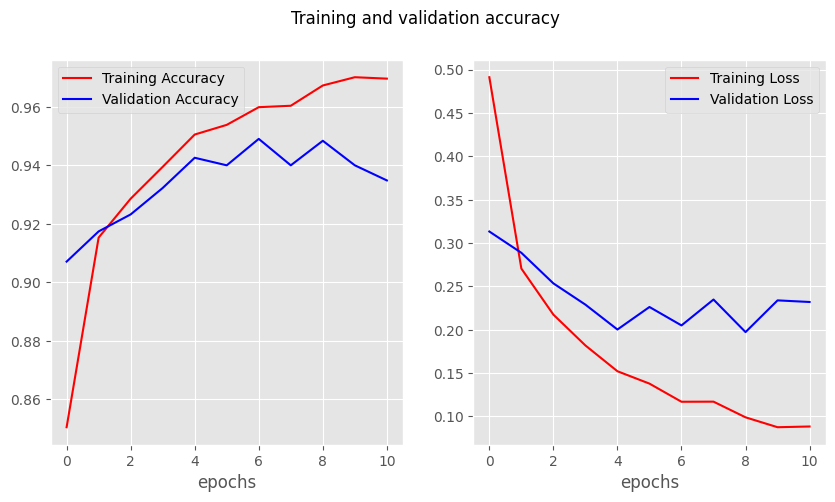

In [23]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [27]:
predictions = Model.predict(testGenerator)

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


In [28]:
trainGenerator.class_indices

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'glass': 5,
 'green-glass': 6,
 'metal': 7,
 'paper': 8,
 'plastic': 9,
 'shoes': 10,
 'trash': 11}

In [29]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9305 - loss: 0.2519


0.9338046312332153

In [30]:
trueClasses = testGenerator.classes
trueClasses[:10]

[0, 4, 4, 1, 4, 4, 10, 4, 1, 11]

In [31]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([ 0,  4,  4,  6,  4,  4, 10,  4,  1, 11])

In [25]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92        95
           1       0.99      0.96      0.97        99
           2       0.92      0.72      0.81        61
           3       0.88      0.94      0.91        90
           4       0.99      0.99      0.99       533
           5       0.83      0.82      0.83        78
           6       0.89      0.92      0.91        63
           7       0.85      0.75      0.80        77
           8       0.95      0.92      0.94       105
           9       0.81      0.91      0.85        87
          10       0.95      0.97      0.96       198
          11       0.96      0.91      0.93        70

    accuracy                           0.93      1556
   macro avg       0.91      0.90      0.90      1556
weighted avg       0.93      0.93      0.93      1556



Class Names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'glass', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Masukkan kategori asli dari gambar: clothes


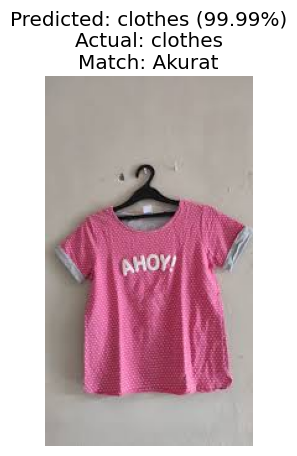

In [26]:
# Import tambahan
import numpy as np

# Fungsi tambahan
def preprocess_image(img_path, img_size=(224, 224)):
    """
    Preprocess an image for prediction.
    :param img_path: Path to the image file
    :param img_size: Target size for resizing (default to match model input size)
    :return: Preprocessed image array
    """
    # Load image and resize
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    # Convert image to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Preprocess image using MobileNetV2's preprocess_input
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    # Expand dimensions to add batch size
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(model, img_path, class_names):
    """
    Predict the class of a single image.
    :param model: Trained model
    :param img_path: Path to the image file
    :param class_names: List of class names
    :return: Predicted class and confidence score
    """
    # Preprocess the image
    img_array = preprocess_image(img_path, img_size=(224, 224))
    # Perform prediction
    predictions = model.predict(img_array, verbose=0)
    # For multi-class classification, get the class with the highest probability
    predicted_class_idx = np.argmax(predictions, axis=-1)[0]
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    return predicted_class, confidence

def visualize_prediction(img_path, predicted_class, confidence, true_label):
    """
    Display the image with predicted and actual labels.
    :param img_path: Path to the image
    :param predicted_class: Predicted class label
    :param confidence: Confidence score
    :param true_label: Actual class label provided by the user
    """
    # Load and display the image
    img = tf.keras.preprocessing.image.load_img(img_path)
    plt.imshow(img)
    plt.title(
        f"Predicted: {predicted_class} ({confidence * 100:.2f}%)\n"
        f"Actual: {true_label}\n"
        f"Match: {'Akurat' if predicted_class.lower() == true_label.lower() else 'Tidak Akurat'}"
    )
    plt.axis("off")
    plt.show()

# Contoh penggunaan
class_names = list(trainGenerator.class_indices.keys())  # Ambil class names dari trainGenerator
print("Class Names:", class_names)

# Path ke gambar uji
test_img_path = "/content/baju-bekas.jpg"  # Sesuaikan dengan path gambar Anda

# Prediksi gambar
predicted_class, confidence = predict_image(Model, test_img_path, class_names)

# Input kategori asli dari pengguna
true_label = input("Masukkan kategori asli dari gambar: ")

# Tampilkan hasil perbandingan
visualize_prediction(test_img_path, predicted_class, confidence, true_label)